In [304]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import rand

# Implementing the screening rule

In [305]:
def compute_prox(x, mu):
    p = np.zeros(x.size)
    for i in range(x.size):
        if np.abs(x[i]) > mu:
            p[i] = (1 - mu / np.abs(x[i])) * x[i]
    return p

def compute_prox_subgradient(u, mu):
    g = np.zeros(u.size)
    for i in range(u.size):
        if np.abs(u[i]) > mu:
            g[i] = 1
        elif np.abs(u[i]) < mu:
            g[i] = 0
        else:
            g[i] = np.random.rand(1)[0]
    return g

def compute_l1_subgradient(u):
    g = np.zeros(u.size)
    for i in range(u.size):
        if u[i] != 0:
            g[i] = np.sign(u[i])
        else:
            g[i] = 2 * np.random.rand(1)[0] - 1
    return g

def compute_subgradient(x, D, y, lmbda, mu):
    output = D.dot(x) - y
    g_1 = compute_prox_subgradient(output, mu)
    g_1 = np.transpose(D).dot(np.diag(g_1))
    g_1 = g_1.dot(compute_prox(output, mu))
    g_2 = compute_l1_subgradient(x)
    g = g_1 + lmbda * g_2
    return g

def update_ellipsoid(z, A, g):
    p = z.size
    A_g = A.dot(g)
    den = np.sqrt(g.dot(A_g))
    g = (1 / den) * g
    A_g = A.dot(g)
    z = z - (1 / (p + 1)) * A_g
    A = (p ** 2 / (p ** 2 - 1)) * (A - (2 / (p + 1)) * np.outer(A_g, A_g))
    return z, A

def iterate_ellipsoids(D, y, z_init, A_init, lmbda, mu, n_steps=100):
    k = 0
    z = z_init
    A = A_init
    while k < n_steps:
        g = compute_subgradient(z, D, y, lmbda, mu)
        z, A = update_ellipsoid(z, A, g)
        k += 1 
    return z, A

def compute_test(D_i, y_i, z, A):
    test_1 = D_i.dot(z) + np.sqrt( (D_i.dot(A.dot(D_i)))/ 2) - y_i
    test_2 = - D_i.dot(z) + np.sqrt( (D_i.dot(A.dot(D_i)))/ 2) + y_i
    return test_1, test_2

def test_dataset(D, y, z, A, mu):
    results = np.zeros(D.shape[0])
    for i in range(D.shape[0]):
        test = compute_test(D[i], y[i], z, A)
        if test[0] < mu and test[1] < mu:
            results[i] = 1
    return results

# Generating the data

In [306]:
#import data, real and synthetic

def make_data(param_set, noise=True):

    n = param_set[0]
    p = param_set[1]
    sparsity = param_set[2]
    X = np.zeros((n,p))
    y = np.zeros(n)
    true_params = rand(p, 1, density = sparsity).A.ravel()
    sparse_ones = np.zeros(p)
    for i in range(p):
        if true_params[i] != 0:
            sparse_ones[i] = 1
    true_params = 2 * true_params - sparse_ones

    noise_norm = 0

    for i in range(n):
        # sample x in [-1,1]^p box
        x = 2 * np.random.rand(p) - np.ones(p) 
        X[i,:] = x
        y[i] = np.dot(true_params,x)
        if noise:
            w = np.random.randn(1) / 10
            y[i] += w
            noise_norm = np.linalg.norm(w)

    return X, y, true_params, noise_norm

param_set = (100, 10, 0.2)
X, y, true_params, _ = make_data(param_set)

# Testing the sreening rule

[ 1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  0.
  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.]


<IPython.core.display.Javascript object>


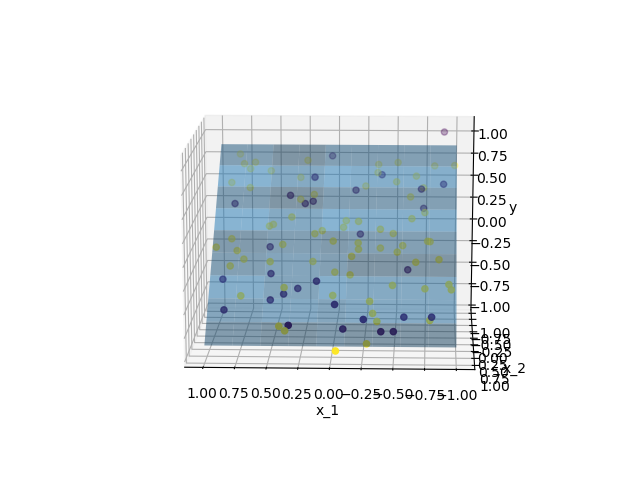

In [323]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D 

# we generate the dataset, find the set X for x and execute the test.
param_set = (100, 2, 1/2)
X, y, true_params, _ = make_data(param_set)
z_init = np.zeros(2)
A_init = 2 * np.identity(2) #TODO: find rule for the radius
lmbda = 0.1 #TODO: find rule for lmbda
mu = 0.1 #TODO: evaluate sensitivity in mu
z, A = iterate_ellipsoids(X, y, z_init, A_init, lmbda, mu)
results = test_dataset(X, y, z, A, mu)
print(results)

visible = True

if visible:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], y, c=results)

    # we plot the plane from which the datapoints are generated
    x_1_true = np.linspace(-1,1,10)
    x_2_true = np.linspace(-1,1,10)
    X_1_true, X_2_true = np.meshgrid(x_1_true, x_2_true)
    y_real = true_params[0] * X_1_true + true_params[1] * X_2_true
    ax.plot_surface(X_1_true, X_2_true, y_real, alpha=0.5)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('y')
    plt.show()